<a href="https://colab.research.google.com/github/myoohit/baby-mood/blob/main/CryBell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa==0.9.2

In [ ]:
!git clone https://github.com/gveres/donateacry-corpus.git

fatal: destination path 'donateacry-corpus' already exists and is not an empty directory.


In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [ ]:
create_pngs_from_wavs('/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/belly_pain','/content/Output/belly_pain')
create_pngs_from_wavs('/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/burping', '/content/Output/burping')
create_pngs_from_wavs('/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/discomfort', '/content/Output/discomfort')
create_pngs_from_wavs('/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/hungry', '/content/Output/hungry')
create_pngs_from_wavs('/content/donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/tired', '/content/Output/tired')

In [ ]:
x = []
y = []

from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

In [ ]:
import glob
import shutil

def move_files(source_pattern, destination_path):
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        print(f"Directory '{destination_path}' created successfully.")
    else:
        print(f"Directory '{destination_path}' already exists.")

    files_to_move = glob.glob(source_pattern)
    for file_path in files_to_move[:-1]:
        shutil.move(file_path, destination_path)

In [ ]:
# Define your directories and source patterns
directories = {
    '/content/Output/belly_pain_train': '/content/Output/belly_pain/*.png',
    '/content/Output/burping_train': '/content/Output/burping/*.png',
    '/content/Output/discomfort_train': '/content/Output/discomfort/*.png',
    '/content/Output/hungry_train': '/content/Output/hungry/*.png',
    '/content/Output/tired_train': '/content/Output/tired/*.png'
}

for directory, source_pattern in directories.items():
    move_files(source_pattern, directory)


Directory '/content/Output/belly_pain_train' already exists.


Error: Destination path '/content/Output/belly_pain_train/ae5f103b-5fee-442f-bb1b-d9d0570c46ab-1431533857965-1.7-m-26-bp.png' already exists

In [ ]:
images, labels = load_images_from_path('/content/Output/belly_pain_train', 0)

x += images
y += labels

images, labels = load_images_from_path('/content/Output/burping_train', 1)

x += images
y += labels

images, labels = load_images_from_path('/content/Output/discomfort_train', 2)

x += images
y += labels

images, labels = load_images_from_path('/content/Output/hungry_train', 3)

x += images
y += labels

images, labels = load_images_from_path('/content/Output/tired_train', 4)

x += images
y += labels

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Normalization, Resizing, InputLayer
from tensorflow.keras.optimizers import AdamW

model = Sequential([
    InputLayer(input_shape=(224, 224, 3)),
    Resizing(64, 64),
    Normalization(),
    Conv2D(64, 3, strides=1, activation='relu'),
    Conv2D(128, 3, strides=1, activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),  # 🔄 Replacing RandomFourierFeatures with Dense
    Dense(5, activation='softmax')  # Output layer (assuming 5 classes)
])

model.compile(optimizer=AdamW(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 64, 3)           │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,822,028 (56.54 MB)

 Trainable params: 14,822,021 (56.54 MB)

 Non-trainable params: 7 (32.00 B)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=2,
                              min_lr=0.006,
                              verbose=1)

hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), epochs=50,callbacks=[reduce_lr])

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7575 - loss: 55.1633 - val_accuracy: 0.8571 - val_loss: 0.8888 - learning_rate: 0.0100
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8332 - loss: 0.7730 - val_accuracy: 0.8571 - val_loss: 0.6816 - learning_rate: 0.0100
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8342 - loss: 0.6348
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.006.
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8346 - loss: 0.6354 - val_accuracy: 0.8571 - val_loss: 0.6212 - learning_rate: 0.0100
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8372 - loss: 0.6329 - val_accuracy: 0.8571 - val_loss: 0.6068 - learning_rate: 0.0060
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8485 - loss: 0.6137 - val_accuracy: 0.8571 - val_loss: 0.6412 - learning_rate: 0.0060
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8389 - loss: 0.6105 - val_accuracy: 0.8571 - val_loss

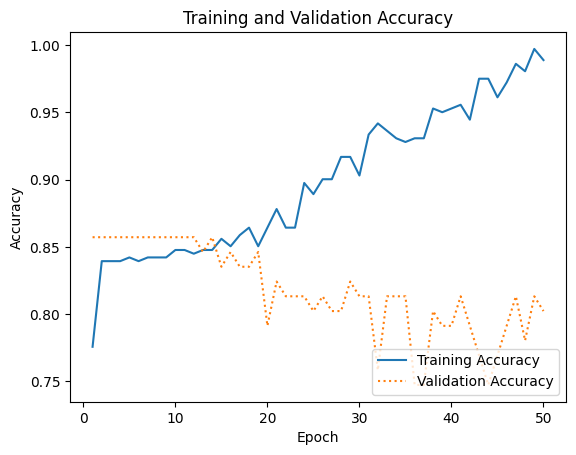

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()
plt.show()

In [ ]:
import glob
import os

def get_png_files(directory):
    folders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
    png_files = []

    for folder_name in folders:
        folder_path = os.path.join(directory, folder_name)
        if os.path.exists(folder_path):
            png_files.extend(glob.glob(os.path.join(folder_path, '*.png')))
        else:
            print(f"Folder '{folder_name}' does not exist in '{directory}'.")

    return png_files

directory_path = '/content/Output'
png_files_list = get_png_files(directory_path)

results = []
for file_path in png_files_list:
    x = image.load_img(file_path, target_size=(224, 224))

    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)

    y = model.predict(x)

    class_labels = ['belly pain','burping','discomfort','hungry','tired']

    # for i, label in enumerate(class_labels):
    #     print(f'{label}: {y[0][i]}')

    results.append(f"Original:{file_path.split('/')[3]} Predicted: {class_labels[np.argmax(y)]}")

print('\n')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━

In [ ]:
# prompt: load my model and download

from google.colab import files
model.save('my_model.h5')
files.download('my_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: run the asset file /content/CryBell-Enhancing-infant-bonding-and-care-through-emotion-awareness/static/assets

!mkdir /content/Output
!mkdir /content/Output/belly_pain_train
!mkdir /content/Output/burping_train
!mkdir /content/Output/discomfort_train
!mkdir /content/Output/hungry_train
!mkdir /content/Output/tired_train
%cd /content/CryBell-Enhancing-infant-bonding-and-care-through-emotion-awareness/static/assets


mkdir: cannot create directory ‘/content/Output’: File exists
mkdir: cannot create directory ‘/content/Output/belly_pain_train’: File exists
mkdir: cannot create directory ‘/content/Output/burping_train’: File exists
mkdir: cannot create directory ‘/content/Output/discomfort_train’: File exists
mkdir: cannot create directory ‘/content/Output/hungry_train’: File exists
mkdir: cannot create directory ‘/content/Output/tired_train’: File exists
/content/CryBell-Enhancing-infant-bonding-and-care-through-emotion-awareness/static/assets


In [ ]:
# prompt: how to run html file with css in collab, /content/CryBell-Enhancing-infant-bonding-and-care-through-emotion-awareness/templates/home.html

from IPython.display import HTML
from google.colab import output
import os

# Path to your HTML file
html_file_path = '/content/CryBell-Enhancing-infant-bonding-and-care-through-emotion-awareness/templates/home.html'

# Function to embed the HTML file with CSS
def embed_html_with_css(html_file_path):
  if not os.path.exists(html_file_path):
    print(f"Error: HTML file not found at {html_file_path}")
    return

  with open(html_file_path, 'r') as f:
    html_content = f.read()

  # You might need to adjust the path to your CSS file
  css_file_path = '/content/CryBell-Enhancing-infant-bonding-and-care-through-emotion-awareness/static/css/styles.css'  # Replace with actual path

  if os.path.exists(css_file_path):
    with open(css_file_path, 'r') as css_file:
      css_content = css_file.read()
      style_tag = f"<style>{css_content}</style>"
      html_content = html_content.replace("</head>", style_tag + "</head>")
  else:
    print(f"Warning: CSS file not found at {css_file_path}")

  return HTML(html_content)


# Display the HTML content in the Colab notebook
output.clear()
display(embed_html_with_css(html_file_path))


In [ ]:
# prompt: /content/CryBell-Enhancing-infant-bonding-and-care-through-emotion-awareness/static/home.css link it to home.html

# Path to your HTML file
html_file_path = '/content/CryBell-Enhancing-infant-bonding-and-care-through-emotion-awareness/templates/home.html'

# Function to embed the HTML file with CSS
def embed_html_with_css(html_file_path):
  if not os.path.exists(html_file_path):
    print(f"Error: HTML file not found at {html_file_path}")
    return

  with open(html_file_path, 'r') as f:
    html_content = f.read()

  # You might need to adjust the path to your CSS file
  css_file_path = '/content/CryBell-Enhancing-infant-bonding-and-care-through-emotion-awareness/static/home.css'  # Replace with actual path

  if os.path.exists(css_file_path):
    with open(css_file_path, 'r') as css_file:
      css_content = css_file.read()
      style_tag = f"<style>{css_content}</style>"
      html_content = html_content.replace("</head>", style_tag + "</head>")
  else:
    print(f"Warning: CSS file not found at {css_file_path}")

  return HTML(html_content)


# Display the HTML content in the Colab notebook
output.clear()
display(embed_html_with_css(html_file_path))


In [ ]:
# prompt: create a stream lit website for my project use ngrok

!pip install streamlit
!pip install pyngrok

import streamlit as st
from pyngrok import ngrok
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import librosa
import librosa.display
import matplotlib.pyplot as plt
import io
import os

# Load your trained model (replace with your actual model path)
model = load_model('/content/my_model.h5')

# Function to create spectrogram from audio
def create_spectrogram(audio_file):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

  y, sr = librosa.load(audio_file)
  ms = librosa.feature.melspectrogram(y, sr=sr)
  log_ms = librosa.power_to_db(ms, ref=np.max)
  librosa.display.specshow(log_ms, sr=sr)

  img_buf = io.BytesIO()
  plt.savefig(img_buf, format='png')
  img_buf.seek(0)
  plt.close(fig)

  return img_buf

# Streamlit app
st.title("Baby Cry Classifier")

uploaded_file = st.file_uploader("Choose an audio file", type=["wav"])

if uploaded_file is not None:
  # Save the uploaded file temporarily
  with open("uploaded_audio.wav", "wb") as f:
    f.write(uploaded_file.getbuffer())

  # Create the spectrogram
  spectrogram_image = create_spectrogram("uploaded_audio.wav")

  # Display spectrogram in Streamlit
  st.image(spectrogram_image, caption="Spectrogram of the uploaded audio")

  # Load and preprocess the spectrogram image
  x = image.load_img(spectrogram_image, target_size=(224, 224))
  x = image.img_to_array(x)
  x = np.expand_dims(x, axis=0)

  # Make a prediction
  y = model.predict(x)

  class_labels = ['belly pain', 'burping', 'discomfort', 'hungry', 'tired']
  predicted_label = class_labels[np.argmax(y)]

  st.write(f"Predicted Cry Reason: {predicted_label}")


# Start ngrok tunnel
ngrok_tunnel = ngrok.connect(8501)
public_url = ngrok_tunnel.public_url
print(f"Streamlit app running on: {public_url}")

# Run Streamlit app
!streamlit run /content/app.py &




OSError: Unable to synchronously open file (truncated file: eof = 4194304, sblock->base_addr = 0, stored_eof = 177908808)

In [ ]:
!pip install streamlit pyngrok

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import io

# Load trained model
@st.cache_resource
def load_model():
    model_path = "/content/my_model.h5"  # Ensure this path is correct
    try:
        model = tf.keras.models.load_model(model_path)
        st.success("✅ Model loaded successfully!")
        return model
    except Exception as e:
        st.error(f"❌ Error loading model: {e}")
        return None

model = load_model()

# Define class labels (Ensure these match your trained model)
class_labels = ['belly pain', 'burping', 'discomfort', 'hungry', 'tired']

# Title
st.title("🚀 Baby Cry Classifier (Audio-Based)")

# User input
name = st.text_input("Enter your name:")
if name:
    st.write(f"Hello, {name}! 👋")

# Audio file upload
uploaded_file = st.file_uploader("Upload an audio file", type=["wav", "mp3", "ogg"])

if uploaded_file and model:
    st.audio(uploaded_file, format="audio/wav")  # Play the uploaded audio

    # Convert uploaded file to a NumPy array
    try:
        y, sr = librosa.load(uploaded_file, sr=22050)  # Load audio with a fixed sample rate
        st.success("✅ Audio file loaded successfully!")

        # Convert to Mel spectrogram (or other format based on your model training)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels

        # Display the spectrogram
        fig, ax = plt.subplots()
        img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel", ax=ax)
        plt.colorbar(img, format="%+2.0f dB")
        plt.title("Mel Spectrogram")

        # Show plot in Streamlit
        st.pyplot(fig)

        # Prepare input for model
        mel_spec_db = np.expand_dims(mel_spec_db, axis=(0, -1))  # Add batch and channel dimensions

        # Predict
        prediction = model.predict(mel_spec_db)
        predicted_label = class_labels[np.argmax(prediction)]

        # Display prediction
        st.subheader(f"🍼 Predicted Class: *{predicted_label}* ✅")

    except Exception as e:
        st.error(f"❌ Error processing audio: {e}")

Overwriting app.py


In [6]:
!streamlit run app.py &> /dev/null &

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import io

# Load trained model
@st.cache_resource
def load_model():
    model_path = "/content/my_model.h5"  # Ensure this path is correct
    try:
        model = tf.keras.models.load_model(model_path)
        st.success("✅ Model loaded successfully!")
        return model
    except Exception as e:
        st.error(f"❌ Error loading model: {e}")
        return None

model = load_model()

# Define class labels (Ensure these match your trained model)
class_labels = ['belly pain', 'burping', 'discomfort', 'hungry', 'tired']

# Title
st.title("🚀 Baby Cry Classifier (Audio-Based)")

# User input
name = st.text_input("Enter your name:")
if name:
    st.write(f"Hello, {name}! 👋")

# Audio file upload
uploaded_file = st.file_uploader("Upload an audio file", type=["wav", "mp3", "ogg"])

if uploaded_file and model:
    st.audio(uploaded_file, format="audio/wav")  # Play the uploaded audio

    # Convert uploaded file to a NumPy array
    try:
        y, sr = librosa.load(uploaded_file, sr=22050)  # Load audio with a fixed sample rate
        st.success("✅ Audio file loaded successfully!")

        # Convert to Mel spectrogram (or other format based on your model training)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels

        # Display the spectrogram
        fig, ax = plt.subplots()
        img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel", ax=ax)
        plt.colorbar(img, format="%+2.0f dB")
        plt.title("Mel Spectrogram")

        # Show plot in Streamlit
        st.pyplot(fig)

        # Prepare input for model
        mel_spec_db = np.expand_dims(mel_spec_db, axis=(0, -1))  # Add batch and channel dimensions

        # Predict
        prediction = model.predict(mel_spec_db)
        predicted_label = class_labels[np.argmax(prediction)]

        # Display prediction
        st.subheader(f"🍼 Predicted Class: *{predicted_label}* ✅")

    except Exception as e:
        st.error(f"❌ Error processing audio: {e}")

Overwriting app.py


In [7]:
from pyngrok import ngrok

public_url = ngrok.connect(8501, "addr", bind_tls=True)

print(f"🌍 Public URL: {public_url}")

ModuleNotFoundError: No module named 'pyngrok'

In [14]:
!pip install pyngrok  # Installs the pyngrok library
from pyngrok import ngrok

public_url = ngrok.connect(8501, "addr", bind_tls=True)

print(f"🌍 Public URL: {public_url}")

PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"Invalid protocol name 'addr'"}}


In [17]:
public_url = ngrok.connect(8501, "http", bind_tls=True)  # Change "addr" to "http"

print(f"🌍 Public URL: {public_url}")

🌍 Public URL: NgrokTunnel: "https://cfe8-34-16-151-26.ngrok-free.app" -> "http://localhost:8501"


In [12]:
!pkill -f ngrok


In [13]:
!ngrok authtoken 2uOLijRQZJjh380fI6MX7AiAa1G_6XRxYpyh9GfAhLxuPSyYg

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [18]:
# prompt: creat a streamlit website for my project called app.py

%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from pyngrok import ngrok
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import io
import os
!pip install librosa==0.9.2

# Load trained model
@st.cache_resource
def load_model():
    model_path = "/content/my_model.h5"  # Ensure this path is correct
    try:
        model = tf.keras.models.load_model(model_path)
        st.success("✅ Model loaded successfully!")
        return model
    except Exception as e:
        st.error(f"❌ Error loading model: {e}")
        return None

model = load_model()

# Define class labels (Ensure these match your trained model)
class_labels = ['belly pain', 'burping', 'discomfort', 'hungry', 'tired']

# Title
st.title("🚀 Baby Cry Classifier (Audio-Based)")

# User input
name = st.text_input("Enter your name:")
if name:
    st.write(f"Hello, {name}! 👋")

# Audio file upload
uploaded_file = st.file_uploader("Upload an audio file", type=["wav", "mp3", "ogg"])

if uploaded_file and model:
    st.audio(uploaded_file, format="audio/wav")  # Play the uploaded audio

    # Convert uploaded file to a NumPy array
    try:
        y, sr = librosa.load(uploaded_file, sr=22050)  # Load audio with a fixed sample rate
        st.success("✅ Audio file loaded successfully!")

        # Convert to Mel spectrogram (or other format based on your model training)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels

        # Display the spectrogram
        fig, ax = plt.subplots()
        img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel", ax=ax)
        plt.colorbar(img, format="%+2.0f dB")
        plt.title("Mel Spectrogram")

        # Show plot in Streamlit
        st.pyplot(fig)

        # Prepare input for model
        mel_spec_db = np.expand_dims(mel_spec_db, axis=(0, -1))  # Add batch and channel dimensions

        # Predict
        prediction = model.predict(mel_spec_db)
        predicted_label = class_labels[np.argmax(prediction)]

        # Display prediction
        st.subheader(f"🍼 Predicted Class: *{predicted_label}* ✅")

    except Exception as e:
        st.error(f"❌ Error processing audio: {e}")


# ngrok tunnel setup (replace with your authtoken)
ngrok_tunnel = ngrok.connect(8501)
public_url = ngrok_tunnel.public_url
print(f"🌍 Public URL: {public_url}")


Overwriting app.py


In [19]:
!streamlit run app.py --server.port 8501

/bin/bash: line 1: streamlit: command not found


In [25]:
ngrok_tunnel = ngrok.connect(addr="8501", proto="http", bind_tls=True) # Ensure this matches streamlit's port

In [24]:
ngrok_tunnel = ngrok.connect(addr="8501", proto="http", bind_tls=True)
public_url = ngrok_tunnel.public_url
print(f"🌍 Public URL: {public_url}")

🌍 Public URL: https://e9a1-34-16-151-26.ngrok-free.app


In [10]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from pyngrok import ngrok
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import io
import os
!pip install librosa==0.9.2

# Load trained model
@st.cache_resource
def load_model():
    model_path = "/content/my_model.h5"  # Ensure this path is correct
    try:
        model = tf.keras.models.load_model(model_path)
        st.success("✅ Model loaded successfully!")
        return model
    except Exception as e:
        st.error(f"❌ Error loading model: {e}")
        return None

model = load_model()

# Define class labels (Ensure these match your trained model)
class_labels = ['belly pain', 'burping', 'discomfort', 'hungry', 'tired']

# Title
st.title("🚀 Baby Cry Classifier (Audio-Based)")

# User input
name = st.text_input("Enter your name:")
if name:
    st.write(f"Hello, {name}! 👋")

# Audio file upload
uploaded_file = st.file_uploader("Upload an audio file", type=["wav", "mp3", "ogg"])

if uploaded_file and model:
    st.audio(uploaded_file, format="audio/wav")  # Play the uploaded audio

    # Convert uploaded file to a NumPy array
    try:
        y, sr = librosa.load(uploaded_file, sr=22050)  # Load audio with a fixed sample rate
        st.success("✅ Audio file loaded successfully!")

        # Convert to Mel spectrogram (or other format based on your model training)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels

        # Display the spectrogram
        fig, ax = plt.subplots()
        img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel", ax=ax)
        plt.colorbar(img, format="%+2.0f dB")
        plt.title("Mel Spectrogram")

        # Show plot in Streamlit
        st.pyplot(fig)

        # Prepare input for model
        mel_spec_db = np.expand_dims(mel_spec_db, axis=(0, -1))  # Add batch and channel dimensions

        # Predict
        prediction = model.predict(mel_spec_db)
        predicted_label = class_labels[np.argmax(prediction)]

        # Display prediction
        st.subheader(f"🍼 Predicted Class: *{predicted_label}* ✅")

    except Exception as e:
        st.error(f"❌ Error processing audio: {e}")


# ngrok tunnel setup (replace with your authtoken)
ngrok_tunnel = ngrok.connect(8501) #This line will now work after authentication
public_url = ngrok_tunnel.public_url
print(f"🌍 Public URL: {public_url}")

Overwriting app.py


In [27]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.0 MB/s eta 0:00:00


In [29]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from pyngrok import ngrok
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import io
import os
!pip install librosa==0.9.2

# Load trained model
@st.cache_resource
def load_model():
    model_path = "/content/my_model.h5"  # Ensure this path is correct
    try:
        model = tf.keras.models.load_model(model_path)
        st.success("✅ Model loaded successfully!")
        return model
    except Exception as e:
        st.error(f"❌ Error loading model: {e}")
        return None

model = load_model()

# Define class labels (Ensure these match your trained model)
class_labels = ['belly pain', 'burping', 'discomfort', 'hungry', 'tired']

# Title
st.title("🚀 Baby Cry Classifier (Audio-Based)")

# User input
name = st.text_input("Enter your name:")
if name:
    st.write(f"Hello, {name}! 👋")

# Audio file upload
uploaded_file = st.file_uploader("Upload an audio file", type=["wav", "mp3", "ogg"])

if uploaded_file and model:
    st.audio(uploaded_file, format="audio/wav")  # Play the uploaded audio

    # Convert uploaded file to a NumPy array
    try:
        y, sr = librosa.load(uploaded_file, sr=22050)  # Load audio with a fixed sample rate
        st.success("✅ Audio file loaded successfully!")

        # Convert to Mel spectrogram (or other format based on your model training)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels

        # Display the spectrogram
        fig, ax = plt.subplots()
        img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel", ax=ax)
        plt.colorbar(img, format="%+2.0f dB")
        plt.title("Mel Spectrogram")

        # Show plot in Streamlit
        st.pyplot(fig)

        # Prepare input for model
        mel_spec_db = np.expand_dims(mel_spec_db, axis=(0, -1))  # Add batch and channel dimensions

        # Predict
        prediction = model.predict(mel_spec_db)
        predicted_label = class_labels[np.argmax(prediction)]

        # Display prediction
        st.subheader(f"🍼 Predicted Class: *{predicted_label}* ✅")

    except Exception as e:
        st.error(f"❌ Error processing audio: {e}")


# ngrok tunnel setup (replace with your authtoken)
ngrok_tunnel = ngrok.connect(8501) #This line will now work after authentication
public_url = ngrok_tunnel.public_url
print(f"🌍 Public URL: {public_url}")

Overwriting app.py


In [30]:
!streamlit run app.py &>/dev/null &


In [31]:
from pyngrok import ngrok

# Kill any previous tunnels
ngrok.kill()

# Start a new tunnel
public_url = ngrok.connect(port="8501")
print(f"🚀 Public URL: {public_url}")


ERROR:pyngrok.process.ngrok:t=2025-03-21T19:53:00+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2025-03-21T19:53:00+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok st

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n.

In [32]:
from pyngrok import ngrok

# Kill any previous tunnels
ngrok.kill()

# Start a new tunnel
public_url = ngrok.connect(port="8501")
print(f"🚀 Public URL: {public_url}")


PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel"}}


In [33]:
from pyngrok import ngrok

# Kill any previous tunnels
ngrok.kill()

# Start a new tunnel, using addr instead of port
public_url = ngrok.connect(addr="8501")  # Specify port using 'addr'
print(f"🚀 Public URL: {public_url}")

ERROR:pyngrok.process.ngrok:t=2025-03-21T19:54:02+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2025-03-21T19:54:02+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok st

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n.

In [42]:
from pyngrok import ngrok

# Kill any existing ngrok processes
ngrok.kill()

# Now start your new tunnel
public_url = ngrok.connect(addr="8501")  # Specify port using 'addr'
print(f"🚀 Public URL: {public_url}")

🚀 Public URL: NgrokTunnel: "https://efe4-34-16-151-26.ngrok-free.app" -> "http://localhost:8501"


In [44]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

In [39]:
!pkill -f streamlit

In [37]:
from pyngrok import ngrok

# Kill any existing ngrok processes (just in case)
ngrok.kill()

# Now start your new tunnel
public_url = ngrok.connect(addr="8501")  # Specify port using 'addr'
print(f"🚀 Public URL: {public_url}")

🚀 Public URL: NgrokTunnel: "https://a842-34-16-151-26.ngrok-free.app" -> "http://localhost:8501"


In [41]:
!pip install streamlit
!pip install pyngrok
!pip install librosa==0.9.2
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.4 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0


In [47]:
from pyngrok import ngrok
import subprocess

# Kill any existing ngrok tunnels
ngrok.kill()

# Start Streamlit in the background
subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"])

# Give Streamlit a moment to start
import time
time.sleep(5)

# Create ngrok tunnel
public_url = ngrok.connect(8501, "http")
print(f"Streamlit app running at: {public_url}")

Streamlit app running at: NgrokTunnel: "https://23e5-34-16-151-26.ngrok-free.app" -> "http://localhost:8501"
